In [1]:
import numpy as np
import pandas as pd
import keras
from keras.datasets import mnist
from PIL import Image
import PIL.ImageOps
import matplotlib.pyplot as plt
%matplotlib inline
#from skimage import transform,io
#import scipy.ndimage as ndimage
#import scipy
#import imageio

Using TensorFlow backend.


In [2]:
(features_train, labels_train), (features_test, labels_test) = mnist.load_data()

In [3]:
features_train = features_train.astype('float32')
features_test = features_test.astype('float32')
features_train /= 255
features_test /= 255

In [4]:
labels_train = keras.utils.to_categorical(labels_train, 10)
labels_test = keras.utils.to_categorical(labels_test, 10)

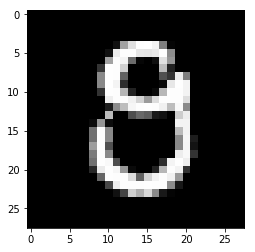

In [5]:
plt.imshow(features_train[80].reshape([28,28]), cmap = 'Greys_r')

In [6]:
out = labels_train[80]
print(out)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


In [7]:
img_rows, img_cols = 28, 28
from keras import backend as K 
if K.image_data_format() == 'channels_first':
    #features_train = features_train.reshape(features_train.shape[0],1, img_rows, img_cols)
    #features_test = features_test.reshape(features_test.shape[0],1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    
else:
    features_train = features_train.reshape(features_train.shape[0], img_rows, img_cols, 1)
    features_test = features_test.reshape(features_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    print("Channels Last.")

Channels Last.


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.optimizers import RMSprop

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu',input_shape = input_shape))
model.add(Conv2D(32,(5,5), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

In [10]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


In [11]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
model.fit(features_train, labels_train, epochs = 1, validation_data = (features_test, labels_test), verbose = 1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/1


In [ ]:
score = model.evaluate(features_test, labels_test, verbose = 0)
print("Test loss:", score[0])
print("Test Accuracy: ", score[1]*100, "%")


### Data augmentation 

In [12]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [13]:
datagen.fit(features_train)

In [14]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
# Fit the model
history = model.fit_generator(datagen.flow(features_train,labels_train, batch_size=128),
                              epochs = 1, validation_data = (features_test,labels_test),
                              verbose = 1, steps_per_epoch=features_train.shape[0] // 128
                              , callbacks=[learning_rate_reduction])

Epoch 1/1
468/468 [==============================] - 18s 39ms/step - loss: 0.5457 - acc: 0.8240 - val_loss: 0.0524 - val_acc: 0.9829


### Save Model on disk

In [18]:
im = Image.open('output.png').convert("L") # returns image object
    #out_img = imread('output.png')
im = PIL.ImageOps.invert(im) 
    #out_img = np.invert(out_img)
im = im.resize((28,28))
    #out_img = imresize(out_img, (28,28))
im = np.reshape(im, (1,28,28,1))
#plt.imshow(im)

FileNotFoundError: [Errno 2] No such file or directory: 'recognition/5.png'

In [118]:
out =model.predict(im)
print(out)
print(np.argmax(out,axis = 1))

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[5]


In [119]:
model_json = model.to_json() 
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [120]:
model.save_weights("model.h5")
print('Model saved to disk.')

Model saved to disk.
